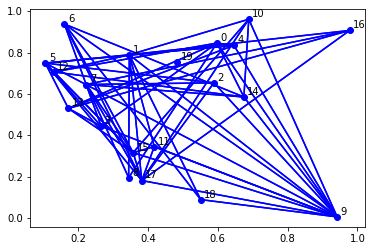

In [1]:
import numpy as np
import algos.graphdrawing as gd
      
V, adj_V = gd.gen_graph(num_verts=20, max_nbrs=10)
gd.draw(V, adj_V)

# Edge-Edge Repulsion (Lin & Yen, 2012)
Apply forces based on the angle formed by incident edges.

Angular resolution: 0.6589805580671759


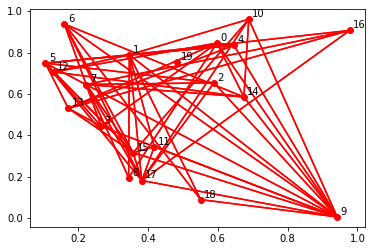

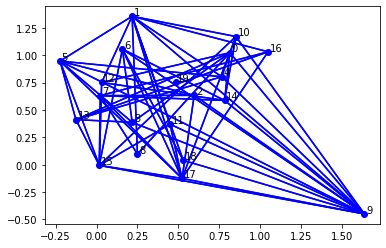

Angular resolution: 0.7355517355411566


In [2]:
import algos.lin_yen as ly
import algos.geometry as geo
import matplotlib.pyplot as plt
from importlib import reload

reload(ly)
gd.draw(V, adj_V, 'r')
print(f'Angular resolution: {geo.get_angular_res(V, adj_V)}')
W = ly.ee_repulsion(V, adj_V, C0=1, C1=0.01)
plt.show()

gd.draw(W, adj_V)
plt.show() 

print(f'Angular resolution: {geo.get_angular_res(W, adj_V)}')

# Force-directed edge-vertex repulsion

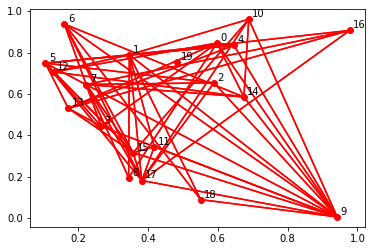

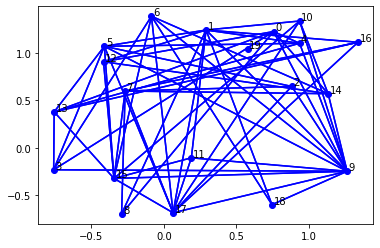

In [3]:
import numpy as np
import math
import algos.lin_yen as ly

      
gd.draw(V, adj_V, 'r')
plt.show()
W = ly.ev_repulsion(V, adj_V, N=10, C1=1, C2=1, C3=0.001)
gd.draw(W, adj_V)
plt.show()

# Vertex-vertex repulsion (Birchfield & Overbye, 2018)

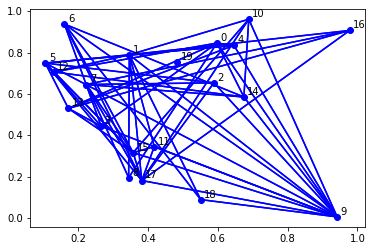

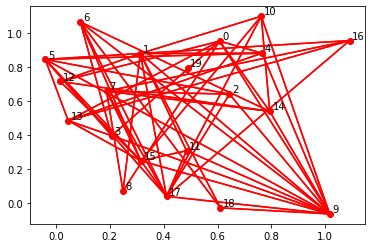

In [4]:
import algos.birchfield as bf
import algos
from importlib import reload

reload(algos.birchfield)
gd.draw(V, adj_V, 'b')
plt.show()
W = bf.force_directed(V, adj_V, N=10, C1=2, C2=0.1, C3=0.005)
gd.draw(W, adj_V, 'r')

# Line intersections

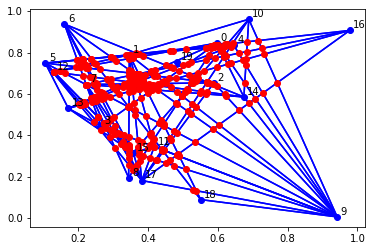

In [5]:
import matplotlib.pyplot as plt
from importlib import reload

ints = geo.get_intersects(V, adj_V)
gd.draw(V, adj_V, 'b')
C = np.array([c['intersection'] for c in ints])
plt.plot(C[:,0], C[:,1], 'ro')
plt.show()

# Used later for cross resolution maximization

# Algorithm for Cross Angular Resolution

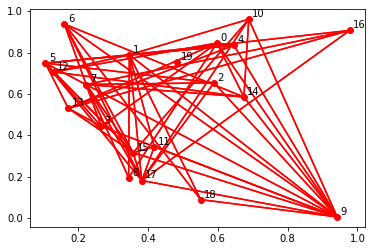

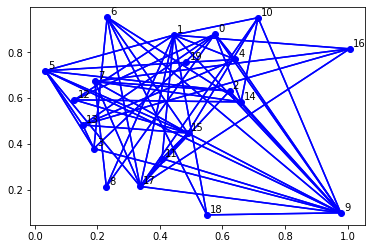

In [6]:
reload(ly)
W = ly.cross_repulsion(V, adj_V, N=15, C0=1, C1=0.001, C2=0.001)
gd.draw(V, adj_V, 'r')
plt.show()
gd.draw(W, adj_V)
plt.show()

# BIGANGLE

Original graph V


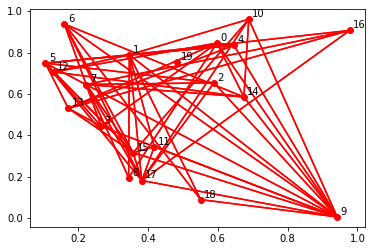

Big angle without forces to original positions


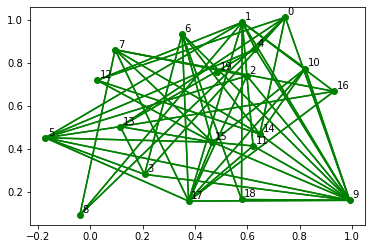

Big angle with forces to original positions


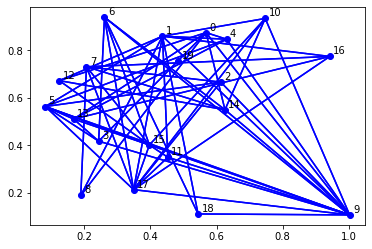

Combined


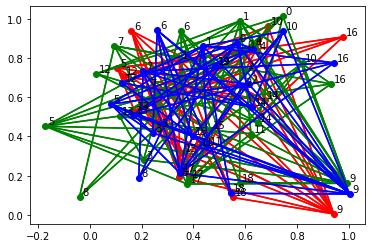

In [7]:
import algos.lin_yen as ly

reload(ly)
print('Original graph V')
gd.draw(V, adj_V, 'r')
plt.show()

print('Big angle without forces to original positions')
W1 = ly.bigangle(V, adj_V, N=15, C0=1, C1=0.01, C2=1, C3=0.001, F2V=False)
gd.draw(W1, adj_V, 'g')
plt.show()

print('Big angle with forces to original positions')
W2 = ly.bigangle(V, adj_V, N=15, C0=500, C1=0.01, C2=1, C3=0.001, F2V=True)
gd.draw(W2, adj_V, 'b')
plt.show()

print('Combined')
gd.draw(V, adj_V, 'r')
gd.draw(W1, adj_V, 'g')
gd.draw(W2, adj_V, 'b')
plt.show()

# Map dingetjes

In [8]:
import pandas as pd
import geopandas as gpd

# Haal de kaart met gemeentegrenzen op van PDOK
geodata_url = 'https://geodata.nationaalgeoregister.nl/cbsgebiedsindelingen/wfs?request=GetFeature&service=WFS&version=2.0.0&typeName=cbs_gemeente_2017_gegeneraliseerd&outputFormat=json'
gemeentegrenzen = gpd.read_file(geodata_url)

<AxesSubplot:>

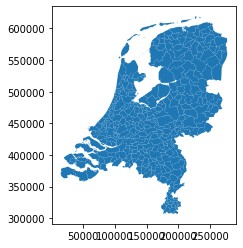

In [9]:
gemeentegrenzen.plot()

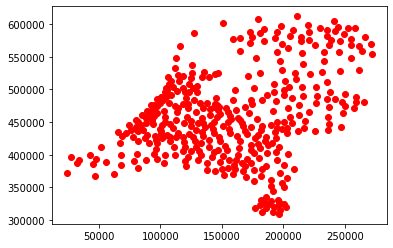

In [10]:
cents = [gem.centroid.xy for gem in gemeentegrenzen['geometry']]
cents = np.array(cents)
plt.plot(cents[:,0], cents[:,1], 'ro')
plt.show()

# Data from Json

# Displacement measure & simple visualization
Darker the 

Total sum of (squared) displacement: 0.13566819697049928


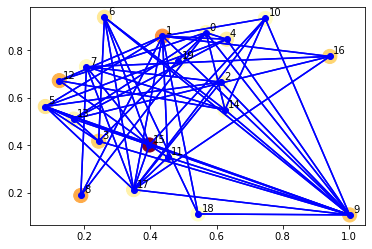

In [11]:
import algos.geometry as geo
from importlib import reload

reload(geo)
disps = geo.get_displacement(V, W)
print(f"Total sum of (squared) displacement: {sum(disps)}")
gd.draw(W2, adj_V, 'b')
plt.scatter(x=W2[:,0], y=W2[:,1], c=disps, s=200, cmap='YlOrRd')
plt.show()

In [12]:
import algos.geometry as geo
from numpy.linalg import norm

ints = geo.get_intersects(W2, adj_V)
L_cam = []
for it in ints:
  i = it['e1'][0]
  j = it['e1'][1]
  k = it['e2'][0]
  l = it['e2'][1]
  ij = W[i] - W[j]
  kl = W[k] - W[l]
  t = [ij, kl]
  b = np.dot(norm(ij), norm(kl))
  L_cam.append((t / b) ** 2)
print(L_cam)

[array([[0.24142937, 0.88693535],
       [0.57067346, 1.20382301]]), array([[0.66915583, 2.45826745],
       [1.75451126, 0.01998521]]), array([[0.34145369, 1.25439315],
       [0.03164052, 1.74285595]]), array([[ 4.25556997, 15.63362169],
       [ 1.37391843,  0.40057804]]), array([[0.73333899, 2.69405611],
       [0.00855852, 1.76593795]]), array([[0.47817582, 1.75666713],
       [0.04576253, 1.72873394]]), array([[1.140606  , 4.19022665],
       [1.75760585, 0.01689062]]), array([[0.60324818, 2.21614352],
       [1.73551647, 0.03898   ]]), array([[0.30494151, 1.12025892],
       [1.57564529, 0.19885118]]), array([[0.57488683, 2.11195287],
       [1.76293181, 0.01156466]]), array([[0.66808876, 2.45434735],
       [1.3226762 , 0.45182027]]), array([[0.16765046, 0.6158949 ],
       [1.24071427, 0.5337822 ]]), array([[0.76069424, 2.79455069],
       [1.30896585, 0.46553062]]), array([[0.6175042 , 2.26851566],
       [0.47126999, 1.30322648]]), array([[0.1664281 , 0.61140436],
       [0.

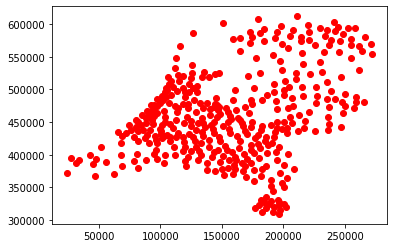

In [18]:
import algos.odf_vis as odf
from importlib import reload

reload(odf)
coords, adj_gem = odf.get_ww()

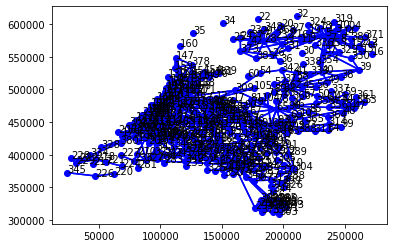

In [31]:
W = ly.bigangle(coords, adj_gem, N=1, C0=1, C1=0.01, C2=1, C3=1, F2V=True)

gd.draw(coords, adj_gem)
plt.show()

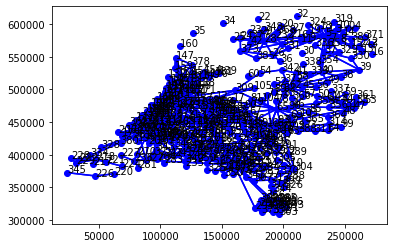

In [33]:
gd.draw(W, adj_gem)
plt.savefig('w.jpg')